In [1]:
import matplotlib.pyplot as plt
import numpy as np
import time
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import os
import sys
sys.path.append("../dataprocess")
import dataprocess as dp

# Parameters for latex rendering
plt.rcParams["text.latex.preamble"] = r"\usepackage{{amsmath}}"
plt.rcParams["text.usetex"] = True

##### Function definitions

In [2]:
def plot_spectrum(s: np.ndarray):
    """Plot the singular value spectrum and normalized cumulative energy

    Args:
        s (np.ndarray): vector containing the singular values
    """
    sigma = s
    sigma_energy = np.cumsum(s)
    # plot singular values and the cumulative energy
    f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 6), dpi=80)
    # plot only up to the first 100 singular values
    ax1.plot(sigma[0:99], "ko", markersize=3)
    ax1.set_xlabel(r"$\text{Modos}$")
    ax1.set_ylabel(r"$\text{Valores singulares}$")
    ax1.set_title(r"$\text{PCA}$")

    ax2.plot(sigma[0:99], "ko", markersize=3)
    ax2.semilogy()
    ax2.set_xlabel(r"$\text{Modos}$")
    ax2.set_ylabel(r"$\text{Valores singulares}$")
    ax2.set_title(r"$\text{PCA, semi log-plot}$")

    ax3.plot(sigma_energy / np.sum(sigma), "ko", markersize=3)
    ax3.set_xlabel(r"$\text{Modos}$")
    ax3.set_ylabel(r"$\text{Energía acumulada}$")
    ax3.set_title(r"$\text{Energía acumulada normalizada}$")
    f.tight_layout()
    f.savefig("PCA_spectrum.png", dpi=300)


def inverse_transf(
    u: np.ndarray,
    s: np.ndarray,
    vh: np.ndarray,
    r_max: int,
    r_step: int,
    X_test: np.ndarray,
):
    """Perform inverse transform and map from the embedded space to the original space

    Args:
        u (np.ndarray): left singular vectors from SVD
        s (np.ndarray): singular values from SVD
        vh (np.ndarray): right singular vectors from SVD
        r_max (int): max number of modes to keep
        r_step (int): mode number increment for calculating the reconstruction error
        X_test (np.ndarray): test data matrix

    Returns:
        X_reconstructed (np.ndarray): reconstructed data with r_max modes
        err_rec (np.ndarray): vector containing the reconstruction error for 1 to r_max modes
    """
    err_rec = np.zeros(len(range(1, r_max + 1, r_step)))
    i = 0
    for r in range(1, r_max + 1, r_step):
        S_r = np.diag(s[0:r])
        U_r = u[:, 0:r]
        Vh_r = vh[0:r, :]
        # X_reconstructed =  np.matmul(np.matmul(X_test, Vh_r.T), Vh_r)
        X_reconstructed = np.matmul(U_r, np.matmul(U_r.T, X_test))
        err_rec[i] = np.linalg.norm(X_test - X_reconstructed) / np.linalg.norm(X_test)
        i += 1
    return X_reconstructed, err_rec

#### Parameters

In [3]:
# Mesh
nx = 227  # X-direction nodes
ny = 120  # Y-direction nodes
# Domain:
Lx = 17.665369  # Lx (Size of the box in x-direction)
Ly = 9.0  # Ly (Size of the box in y-direction)
# Cylinder coordinates:
X_0 = 2.66537  # X coordinate of the center
Y_0 = 4.5  # Y coordinate of the center
r = 0.5  # Cylinder radius

mesh = dp.Mesh(nx, ny, Lx, Ly, X_0, Y_0, r)

# Data path
re = 200
input_dir = "../data/"
input_filename = f'modVcropRe{re}.csv'
# Max number of components and step for postprocess
r_max = 12
r_step = 1

#### Data pre-processing

In [4]:
""" Read velocity data
  X - velocity module
 rows of X correspond to velocity components at spatial locations
 columns of X correspond to timesteps
     t_1 t_2.  .  t_n
 X = [u  u  .  .  .]  (x_1,y_1)
     [v  v  .  .  .]  (x_1,y_1)
     [w  w  .  .  .]  (x_1,y_1)
     [u  u  .  .  .]  (x_2,y_2)
     [v  v  .  .  .]  (x_2,y_2)
     [w  w  .  .  .]  (x_2,y_2)
     [.  .  .  .  .]   .
     [.  .  .  .  .]   .
     [.  .  .  .  .]   .
"""

input_filename = f"modVcropRe{re}.csv"
X = dp.read_X_csv(input_dir + input_filename)
X_train, X_test = train_test_split(
    X.T,
    test_size=0.5,
    shuffle=False,
)
X_train = X_train.T
X_test = X_test.T

n, m = X_train.shape
print("Data matrix X is n by m:", n, "x", m, flush=True)

# Erase cylinder from snapshot
X_train_filt = dp.erase_cyl(X_train, mesh)
X_test_filt = dp.erase_cyl(X_test, mesh)

spatial_red = True
# Standardize data. Sklearn uses differente notation from ours!!
std_scaler = StandardScaler()
if spatial_red:
    #computes temporal mean (row-wise mean)
    X_train_filt = std_scaler.fit_transform(X_train_filt.T).T
    X_test_filt = std_scaler.fit_transform(X_test_filt.T).T
else:
    #computes spatial mean (column-wise mean)
    X_train_filt = std_scaler.fit_transform(X_train_filt)
    X_test_filt = std_scaler.fit_transform(X_test_filt)

Reading data from: ../data/modV_train/modV_crop_re200.csv
Reading data from: ../data/modV_test/modV_crop_re200.csv
Data matrix X is n by m: 27240 x 1000
Snapshot points without cylinder (27104,)


#### Perform PCA

In [5]:
# First, center data
start = time.time()
u, s, vh = np.linalg.svd(X_train_filt, full_matrices=False)
end = time.time()
print("Time elapsed for PCA:", end - start, " s")

Time elapsed for PCA: 1.6414015293121338  s


In [6]:
print(type(u), type(s), type(vh))
print(u.shape, s.shape, vh.shape)

<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
(27104, 1000) (1000,) (1000, 1000)


### Post-process

##### Singular value spectrum and normalized cumulative energy

In [39]:
plot_spectrum(s)

#### Save and plot PCA modes

In [40]:
# save modes in csv and png files
save_flag = False
if save_flag:
    out_dir = "modes/"
    modesToSave = r_max
    dp.save_modes(u, out_dir, modesToSave, mesh)

##### Data reconstruction

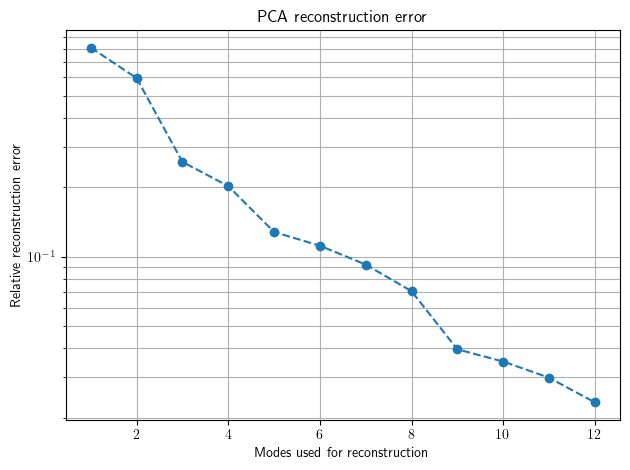

In [41]:
X_reconstructed, err_rec = inverse_transf(u, s, vh, r_max, r_step, X_test_filt)
# Save reconstruction errors for further post-processing
np.savetxt("error_rec.csv", err_rec, delimiter=",")
dp.plot_save_reconst(err_rec, r_max, r_step)